<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/JARVIS_WTBH_Database_of_Wannier_tight_binding_Hamiltonians_using_high_throughput_density_functional_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Database of Wannier tight-binding Hamiltonians using high-throughput density functional theory](https://www.nature.com/articles/s41597-021-00885-z)

In [1]:
!pip install jarvis-tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Available Wannier-tight binding Hamiltonians
from jarvis.db.figshare import data
wann = data('raw_files')['WANN']

Obtaining raw io files 145k...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.


In [3]:
print(len(wann))

1772


In [4]:
#Example entry
wann[0]

{'computed_md5': '35c727d16a403a20cb769214a0c0c2f8',
 'download_url': 'https://ndownloader.figshare.com/files/23119469',
 'id': 23119469,
 'is_link_only': False,
 'name': 'JVASP-28502.zip',
 'size': 12891792,
 'supplied_md5': '35c727d16a403a20cb769214a0c0c2f8'}

**Each of the zip file contains the files in the following format:**

INCAR,  JVASP-28502.json,  JVASP-28502.png,  KPOINTS,  KPOINTS.bands,  OSZICAR,  OUTCAR,  POSCAR,  wannier90.eig,  wannier90.win,  wannier90.wout,  wannier90_hr.dat

The .json file contains details of the bandstructure

In [5]:
# Helper function for band structure
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def band_diagram(eigs=[], labels=[], en_dos=[], dos=[], pdos=[]):
    fig = plt.figure(figsize=(20, 10))
    plt.rcParams.update({"font.size": 22})
    the_grid = GridSpec(1, 2)
    plt.subplot(the_grid[0])
    plt.title("Bandstructure")
    for i, ii in enumerate(eigs):
        plt.plot(ii, color="b")
    
    plt.axhline(y=0,c='g')
    if labels != []:
        kp_labels_points = []
        kp_labels = []
        for k, kk in enumerate(labels):
            if kk != "":
                kp_labels_points.append(k)
                kp_labels.append(kk)
        plt.xticks(kp_labels_points, kp_labels)
    plt.ylabel("Energy (E-E$_f$) (eV)")
    plt.xlim([0, eigs.shape[1] - 1])
    plt.ylim([-4, 4])
    # plt.axhline(y=0,linestyle='-.',c='g')

    plt.subplot(the_grid[1])
    # plt.axvline(y=0,linestyle='-.',c='g')
    plt.title("Density of states")
    
    plt.axvline(x=0,c='g')
    plt.plot(en_dos, dos)
    plt.ylim(0, max(dos))
    plt.xlim([-4, 4])
    plt.xlabel("Energy(eV)")
    plt.ylabel("DOS")

    plt.tight_layout()
    return plt


Obtaining raw io files 145k...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.
H size 9 9 9 40 40
DOS BAND GAP  0.1864157275288605      -0.05180298519011517   0.13461274233874532
np.sum(dos)  40.00000000000001


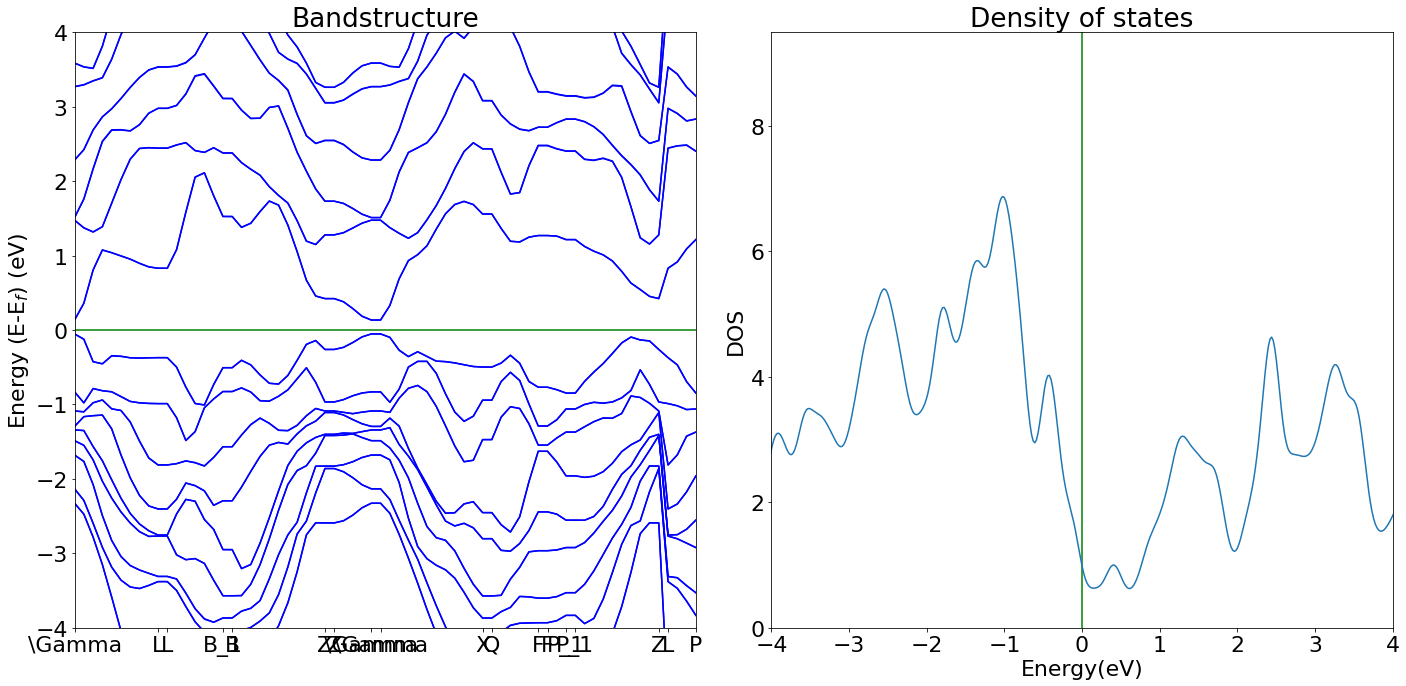

In [6]:
import os,zipfile,tempfile,requests,io
from jarvis.io.wannier.outputs import WannierHam
from jarvis.core.atoms import Atoms
from jarvis.io.vasp.inputs import Poscar
from jarvis.db.figshare import data
from jarvis.core.kpoints import Kpoints3D, generate_kgrid
from jarvis.db.jsonutils import loadjson


# Example: Bi3Se3 (JVASP-1067)
jid = 'JVASP-1067'
# from jarvis.db.figshare import get_wann_electron
# wtbh, ef, atoms = get_wann_electron(jid=jid)

def get_wann_electron(jid="JVASP-816"):
    """Download electron WTBH if available."""
    w = ""
    ef = ""
    fls = data("raw_files")
    for i in fls["WANN"]:
        if i["name"].split(".zip")[0] == jid:
            # Download zip file, unzip and process
            r = requests.get(i["download_url"])
            z = zipfile.ZipFile(io.BytesIO(r.content))
            wdat = z.read("wannier90_hr.dat").decode("utf-8")
            js_file = jid + ".json"
            js = z.read(js_file).decode("utf-8")
            fd, path = tempfile.mkstemp()
            with os.fdopen(fd, "w") as tmp:
                tmp.write(wdat)
            # Make Wannier Hamiltonian object
            w = WannierHam(path)
            fd, path = tempfile.mkstemp()
            with os.fdopen(fd, "w") as tmp:
                tmp.write(js)
            d = loadjson(path)
            ef = d["info_mesh"]["efermi"]
            maxdiff_bz = round(d["info_bz"]["maxdiff"], 3)
            maxdiff_mesh = round(d["info_mesh"]["maxdiff"], 3)
            fd, path = tempfile.mkstemp()
            pos = z.read("POSCAR").decode("utf-8")
            with os.fdopen(fd, "w") as tmp:
                tmp.write(pos)
            atoms = Poscar.from_file(path).atoms
    return w, ef, atoms, d

# Bi2Se3
wtbh, efermi, atoms, json_dat = get_wann_electron(jid=jid)


# Make bandstructure
# Choose a k-point mesh
# kpts = generate_kgrid([5,5,5])
# or high-symmetry kpoints for an Atoms object
line_density = 10

kpoints = Kpoints3D().kpath(atoms, line_density=line_density)
kpts = kpoints.kpts 
labels = kpoints.labels
eigs = wtbh.band_structure_eigs(kpath=kpts, efermi=efermi).T

en_dos, dos, pdos = wtbh.dos(kpoints=kpts, efermi=efermi, sig=0.1, nenergy=1000)

ax = band_diagram(eigs=eigs, labels=labels, en_dos=en_dos, dos=dos, pdos=pdos)


In [7]:
json_dat['info_bz'].keys()

dict_keys(['eigs_vrun', 'kp_labels_points', 'efermi', 'maxdiff', 'kp_labels', 'eigs_wan'])

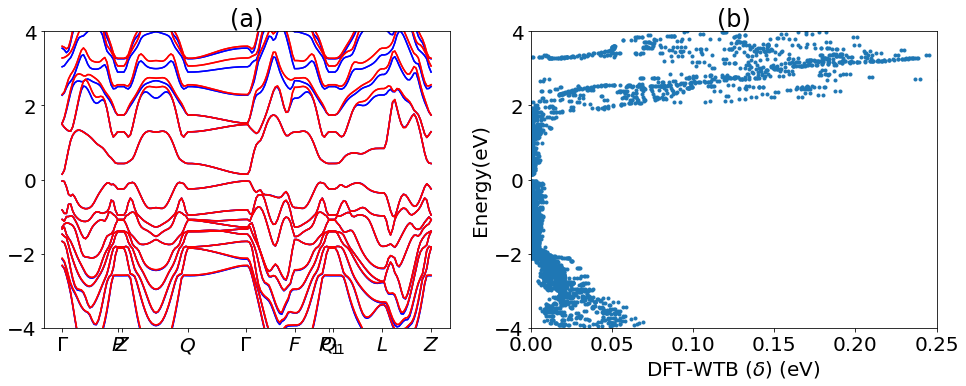

In [8]:
#COMAPRISON PLOTS 

www = json_dat

from jarvis.db.jsonutils import loadjson
from matplotlib.gridspec import GridSpec
import numpy as np
from matplotlib.ticker import PercentFormatter
the_grid = GridSpec(2, 2)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,12))

plt.subplot(the_grid[0, 0])
plt.title('(a)')

for  i,ii in enumerate(np.array(www['info_bz']['eigs_vrun']).T):
                        plt.plot(ii,c='b')
for  i,ii in enumerate(np.array(www['info_bz']['eigs_wan']).T):
                        plt.plot(ii,c='r')
plt.ylim([-4,4])

energy_tol=4
min_arr = []
erange = [-energy_tol, energy_tol]
dd={}
kpp=www['info_bz']['eigs_vrun']#www['info_bz']['eigs_vrun']['kp_labels_points']
vasp=np.array(www['info_bz']['eigs_vrun'])
wann=np.array(www['info_bz']['eigs_wan'])
for k in range(len(kpp)):
    for n in wann[k]:
        diff_arr = []
        if n > erange[0] and n < erange[1]:
            for v in vasp[k]:
                diff = abs(n - v)
                diff_arr.append(diff)
        if diff_arr != []:
            tmp = np.min(diff_arr)
            dd.setdefault(n,tmp)
            min_arr.append(tmp)
plt.xticks(www['info_bz']['kp_labels_points'],www['info_bz']['kp_labels'])
plt.subplot(the_grid[0, 1])
plt.title('(b)')
plt.axhline(y=-5,linestyle='-.',linewidth=4)
plt.axhline(y=5,linestyle='-.',linewidth=4)
plt.xlim([0.,0.25])
plt.ylim([-4,4])
plt.ylabel('Energy(eV)')
plt.xlabel('DFT-WTB ($\delta$) (eV)')
plt.plot(list(dd.values()),list(dd.keys()),'.')

In [9]:
import numpy as np
# Aluminum
wtbh, efermi, atoms, json_dat = get_wann_electron(jid='JVASP-816')
img = wtbh.fermi_surf_2d(fermi=efermi,  origin=np.array([-1.0, -1.0, 0]),k1=np.array([4.0, 0.0, 0.0]),k2=np.array([0.0, 4.0, 0.0]),nk1=50,nk2=50,sig=0.3,)

Obtaining raw io files 145k...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.
H size 15 13 15 8 8


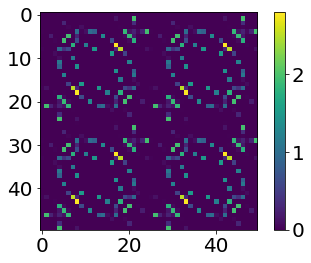

In [10]:
plt.imshow(img)
plt.colorbar()